In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt 
from math import *
from skimage import color

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test', 'train', 'train_ship_segmentations.csv']


In [2]:
train = os.listdir('../input/train')
print(len(train))

test = os.listdir('../input/test')
print(len(test))

1258
917


In [3]:
submission = pd.read_csv('../input/sample_submission.csv')
submission.head()

ImageId EncodedPixels
0  00002bd58.jpg           1 2
1  00015efb6.jpg           1 2
2  00023d5fc.jpg           1 2
3  000367c13.jpg           1 2
4  0008ca6e9.jpg           1 2

In [4]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [5]:
masks = pd.read_csv('../input/train_ship_segmentations.csv')
masks.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [6]:
def get_cotes(Param_1, Param_2, Param_3, Param_4, DEBUG):
    A = Param_1
    B = Param_2
    C = Param_3
    D = Param_4
    #Top = A   Bottom = B    Right = C    Left = D
        #On va tester si les droites se croisent pour obtenir les diagonales du rectangle "bateau"
    #Equation Top,Bottom    y=mx+p
    m1 = 0
    if((B[0]-A[0])!=0):
        m1 = (B[1]-A[1])/(B[0]-A[0]) #m=(yB−yA)/(xB−xA)
    p1 = A[1] - m1*A[0] #p=yA−mxA
    #Equation Right,Left
    m2 = 0
    if((D[0]-C[0])!=0):
        m2 = (D[1]-C[1])/(D[0]-C[0]) #m=(yB−yA)/(xB−xA)
    p2 = C[1] - m2*C[0] #p=yA−mxA
    #Les droites se croisent-elles ?
    x1 = 0
    if((m1 - m2)!=0):
        x1 = (p2 - p1) / (m1 - m2)
    #print("x1 = ", x1)

    #Equation Top,Right
    m1 = 0
    if((C[0]-A[0])!=0):
        m1 = (C[1]-A[1])/(C[0]-A[0]) #m=(yB−yA)/(xB−xA)
    p1 = A[1] - m2*A[0] #p=yA−mxA
    #Equation Bottom,Left
    m2 = 0
    if((D[0]-B[0])!=0):
        m2 = (D[1]-B[1])/(D[0]-B[0]) #m=(yB−yA)/(xB−xA)
    p2 = B[1] - m2*B[0] #p=yA−mxA
    #Les droites se croisent-elles ?
    x2 = 0
    if((m1 - m2)!=0):
        x2 = (p2 - p1) / (m1 - m2)
    #print("x2 = ", x2)

    #Equation Top,Left
    m1 = 0
    if((D[0]-A[0])!=0):
        m1 = (D[1]-A[1])/(D[0]-A[0]) #m=(yB−yA)/(xB−xA)
    p1 = A[1] - m2*A[0] #p=yA−mxA
    #Equation Bottom,Right
    m2 = 0
    if((C[0]-B[0])!=0):
        m2 = (C[1]-B[1])/(C[0]-B[0]) #m=(yB−yA)/(xB−xA)
    p2 = B[1] - m2*B[0] #p=yA−mxA
    #Les droites se croisent-elles ?
    x3 = 0
    if((m1 - m2)!=0):
        x3 = (p2 - p1) / (m1 - m2)
    #print("x3 = ", x3)

    liste_Contours_coord = [A,C, A,D, B,C, B,D]
    if(DEBUG>1):
        print("Diagonale : ")
    if((x1 >= A[0]) & (x1 <= B[0])):
        if(DEBUG>1):
            print("c'est x1 le milieu")
            print("Top <-> Bottom + Right <-> Left")
        liste_Contours_coord = [A,C, A,D, B,C, B,D]
    if((x2 >= A[0]) & (x2 <= B[0])):
        if(DEBUG>1):
            print("c'est x2 le milieu")
            print("Top <-> Right + Bottom <-> Left")
        liste_Contours_coord = [A,B, A,D, B,C, C,D]
    if((x3 >= A[0]) & (x3 <= B[0])):
        if(DEBUG>1):
            print("c'est x3 le milieu")
            print("Top <-> Left + Bottom <-> Right")
        liste_Contours_coord = [A,B, A,C, B,C, C,D]
        #PB ICI, il manque des cas

    return liste_Contours_coord

In [7]:
def get_long(liste_Contours_coord):
    long_1 = [0,0]
    long_2 = [0,0]

    D_1 = sqrt((abs(liste_Contours_coord[1][0]-liste_Contours_coord[0][0]))**2 + (abs(liste_Contours_coord[1][1]-liste_Contours_coord[0][1]))**2)
    D_2 = sqrt((abs(liste_Contours_coord[3][0]-liste_Contours_coord[2][0]))**2 + (abs(liste_Contours_coord[3][1]-liste_Contours_coord[2][1]))**2)
    D_3 = sqrt((abs(liste_Contours_coord[5][0]-liste_Contours_coord[4][0]))**2 + (abs(liste_Contours_coord[5][1]-liste_Contours_coord[4][1]))**2)
    D_4 = sqrt((abs(liste_Contours_coord[7][0]-liste_Contours_coord[6][0]))**2 + (abs(liste_Contours_coord[7][1]-liste_Contours_coord[6][1]))**2)
    listeContours = [D_1,D_2,D_3,D_4]

    #Trouve les 2 cotés les plus longs
    length=len(listeContours)
    max1 = 0
    indice_max1 = 0
    i = 0
    #coté 1
    for i in range(length):
        if listeContours[i] >= max1:
            max1 = listeContours[i]
            indice_max1 = i
    long_1[0] = liste_Contours_coord[indice_max1*2]
    long_1[1] = liste_Contours_coord[indice_max1*2+1]
    del listeContours[indice_max1]
    del liste_Contours_coord[indice_max1*2]
    del liste_Contours_coord[indice_max1*2]
    #coté 2
    length=len(listeContours)
    max2 = 0
    indice_max2 = 0
    i = 0
    for i in range(length):
        if listeContours[i] >= max2:
            max2 = listeContours[i]
            indice_max2 = i
    long_2[0] = liste_Contours_coord[indice_max2*2]
    long_2[1] = liste_Contours_coord[indice_max2*2+1]
    del listeContours[indice_max2]
    del liste_Contours_coord[indice_max2*2]
    del liste_Contours_coord[indice_max2*2]

    liste_long = [long_1[0], long_1[1], long_2[0], long_2[1]]

    return liste_long

In [8]:
def get_court(liste_Contours_coord_2):
    court_1 = [0,0]
    court_2 = [0,0]

    D_1 = sqrt((abs(liste_Contours_coord_2[1][0]-liste_Contours_coord_2[0][0]))**2 + (abs(liste_Contours_coord_2[1][1]-liste_Contours_coord_2[0][1]))**2)
    D_2 = sqrt((abs(liste_Contours_coord_2[3][0]-liste_Contours_coord_2[2][0]))**2 + (abs(liste_Contours_coord_2[3][1]-liste_Contours_coord_2[2][1]))**2)
    D_3 = sqrt((abs(liste_Contours_coord_2[5][0]-liste_Contours_coord_2[4][0]))**2 + (abs(liste_Contours_coord_2[5][1]-liste_Contours_coord_2[4][1]))**2)
    D_4 = sqrt((abs(liste_Contours_coord_2[7][0]-liste_Contours_coord_2[6][0]))**2 + (abs(liste_Contours_coord_2[7][1]-liste_Contours_coord_2[6][1]))**2)
    listeContours = [D_1,D_2,D_3,D_4]

    #Trouve les 2 cotés les plus longs
    length=len(listeContours)
    min1 = 1000
    indice_min1 = 0
    i = 0
    #coté 1
    for i in range(length):
        if listeContours[i] < min1:
            min1 = listeContours[i]
            indice_min1 = i
    court_1[0] = liste_Contours_coord_2[indice_min1*2]
    court_1[1] = liste_Contours_coord_2[indice_min1*2+1]
    del listeContours[indice_min1]
    del liste_Contours_coord_2[indice_min1*2]
    del liste_Contours_coord_2[indice_min1*2]
    #coté 2
    length=len(listeContours)
    min2 = 0
    indice_min2 = 0
    i = 0
    for i in range(length):
        if listeContours[i] < min2:
            min2 = listeContours[i]
            indice_min2 = i
    court_2[0] = liste_Contours_coord_2[indice_min2*2]
    court_2[1] = liste_Contours_coord_2[indice_min2*2+1]
    del listeContours[indice_min2]
    del liste_Contours_coord_2[indice_min2*2]
    del liste_Contours_coord_2[indice_min2*2]

    liste_court = [court_1[0], court_1[1], court_2[0], court_2[1]]

    return liste_court

In [9]:
def limit(X_min, Y_min,X_max, Y_max, A):
    if(A[0] < X_min):
        A[0] = X_min
    if(A[1] < Y_min):
        A[1] = Y_min
    if(A[0] > X_max):
        A[0] = X_max
    if(A[1] > Y_max):
        A[1] = Y_max
    return A

In [10]:
from shapely.geometry import Point, Polygon #pip install shapely
#p1.within(poly)     # True
#poly.contains(p1)   # True

def is_within(X, A, B, C, D):
    coords = [A, B, C, D]
    poly = Polygon(coords)

    p1 = Point(X[0], X[1])
    p1.within(poly)     
    
    return p1.within(poly)

#Test exemple 1
X1 = [24.82, 60.24]
Test1 = is_within(X1,[24.89, 60.06], [24.75, 60.06], [24.75, 60.30], [24.89, 60.30] )
print("Is Within ? ",Test1)

#Test exemple 2
X2 = [24.895, 60.05]
Test2 = is_within(X2,[24.89, 60.06], [24.75, 60.06], [24.75, 60.30], [24.89, 60.30] )
print("Is Within ? ",Test2)

Is Within ?  True
Is Within ?  False


In [11]:
def get_pair(A, B, cote_1_C, cote_1_D, cote_2_C, cote_2_D):

    milieu_AB = [((A[0] + B[0])/2), ((A[1] + B[1])/2)]
    milieu_C1 = [((cote_1_C[0] + cote_1_D[0])/2), ((cote_1_C[1] + cote_1_D[1])/2)]
    milieu_C2 = [((cote_2_C[0] + cote_2_D[0])/2), ((cote_2_C[1] + cote_2_D[1])/2)]

    D_1 = sqrt((abs(milieu_AB[0]-milieu_C1[0]))**2 + (abs(milieu_AB[1]-milieu_C1[1]))**2)
    D_2 = sqrt((abs(milieu_AB[0]-milieu_C2[0]))**2 + (abs(milieu_AB[1]-milieu_C2[1]))**2)

    test = 0
    if(D_1 > D_2):
        test = 1
    
    return test

In [12]:
def get_MinMax(A, B, C, D):
    list = [A, B, C, D]
    max_X = 0
    min_X = 0
    max_Y = 1000
    min_Y = 1000
    i = 0
    for i in range(len(list)):
        if(list[i][0] > max_X):
            max_X = list[i][0]
        if(list[i][1] > max_Y):
            max_Y = list[i][1]
        if(list[i][0] < min_X):
            min_X = list[i][0]
        if(list[i][1] < min_Y):
            min_Y = list[i][1]

    list_final = [min_X, min_Y, max_X, max_Y]

    return list_final

In [13]:
def get_Top_Bottom_Right_Left(mask_test, DEBUG):
    left_list = []
    left_list.append([0,999])
    right_list = []
    right_list.append([0,0])
    top_list = []
    top_list.append([999,0])
    bottom_list = []
    bottom_list.append([0,0])
    for i in range(768):
        for j in range(768):
            if (mask_test[i][j]==1):
                if(j<left_list[0][1]):
                    left_list = []
                    left_list.append([i,j])
                else:
                    if(j==left_list[0][1]):
                        left_list.append([i,j])
                if (j>right_list[0][1]):
                    right_list = []
                    right_list.append([i,j])
                else:
                    if(j==right_list[0][1]):
                        right_list.append([i,j])
                if(i>bottom_list[0][0]):
                    bottom_list = []
                    bottom_list.append([i,j])
                else:
                    if(i==bottom_list[0][0]):
                        bottom_list.append([i,j])
                if(i<top_list[0][0]):
                    top_list = []
                    top_list.append([i,j])
                else: 
                    if(i==top_list[0][0]):
                        top_list.append([i,j])


    #print ("top : ", top_list)
    #print ("bottom : ", bottom_list)
    #print ("left : ",left_list)
    #print ("right : ",right_list)

    #top et bottom sont toujours opposé donc si bottom a droite top plus a guache et inversement
    topsum=0
    mintop=[999,999]
    maxtop=[0,0]
    bottomsum=0
    minbottom=[999,999]
    maxbottom=[0,0]
    leftsum=0
    minleft=[999,999]
    maxleft=[0,0]
    rightsum=0
    minright=[999,999]
    maxright=[0,0]
    for i in range(len(top_list)):
        topsum+=top_list[i][1]
        if top_list[i][1]>maxtop[1]:
            maxtop= top_list[i]
        if top_list[i][1]<mintop[1]:
            mintop= top_list[i]
    for i in range(len(bottom_list)):
        bottomsum+=bottom_list[i][1]
        if bottom_list[i][1]>maxbottom[1]:
            maxbottom= bottom_list[i]
        if bottom_list[i][1]<minbottom[1]:
            minbottom= bottom_list[i]
    for i in range(len(left_list)):
        rightsum+=left_list[i][0]
        if left_list[i][0]>maxleft[0]:
            maxleft= left_list[i]
        if left_list[i][0]<minleft[0]:
            minleft= left_list[i]
    for i in range(len(right_list)):
        rightsum+=right_list[i][0]
        if right_list[i][0]>maxright[0]:
            maxright= right_list[i]
        if right_list[i][0]<minright[0]:
            minright= right_list[i]

    topsum=topsum/len(top_list)
    bottomsum=bottomsum/len(bottom_list)
    leftsum=leftsum/len(left_list)
    rightsum=rightsum/len(right_list)

    top=[]
    bottom = []
    right = []
    left =[]

    if topsum-bottomsum<0:
        bottom=maxbottom
        top=mintop
    else: 
        bottom=minbottom
        top=maxtop

    if leftsum-rightsum<0:
        right=maxright
        left=minleft
    else:
        right=minright
        left=maxleft

    if(DEBUG>1):
        print("right : ",right)
        print("left : ",left)
        print("bottom",bottom)
        print("top : ", top)
        print("")

    return [top, bottom, right, left]


In [14]:
def get_triangle(top, bottom, right, left, img, img3, mask_T2, mask_T3, DEBUG):
    #Dessine les croix des 4 coins
    #for i in range(10):
    #    img[top[0]+i-5, top[1]] = [0, 255, 0]
    #    img[top[0], top[1]+i-5] = [0, 255, 0]
    #    img[bottom[0]+i-5, bottom[1]] = [0, 255, 0]
    #    img[bottom[0], bottom[1]+i-5] = [0, 255, 0]
    #    img[right[0]+i-5, right[1]] = [0, 255, 0]
    #    img[right[0], right[1]+i-5] = [0, 255, 0]
    #    img[left[0]+i-5, left[1]] = [0, 255, 0]
    #    img[left[0], left  [1]+i-5] = [0, 255, 0]

    #####
    liste_Contours_coord = get_cotes(top, bottom, right, left, DEBUG) #On trouve les 4 cotés (on élimine les diagonales du carré)
    if(DEBUG>1):
        print("Liste Contours Coord = ",liste_Contours_coord)
    liste_long = get_long(liste_Contours_coord) #On trouve les 2 cotés les plus long
    long_1 = [liste_long[0],liste_long[1]] 
    long_2 = [liste_long[2],liste_long[3]]
    court_1 = [liste_Contours_coord[0],liste_Contours_coord[1]]
    court_2 = [liste_Contours_coord[2],liste_Contours_coord[3]]

    #On crée les 4 marqueurs autour du bateau
    constant = 1.5
    A = [(int)(constant*(long_1[0][0]-long_1[1][0]))+long_1[0][0],(int)(constant*(long_1[0][1]-long_1[1][1]))+long_1[0][1]]
    C = [(int)(constant*(long_1[1][0]-long_1[0][0]))+long_1[1][0],(int)(constant*(long_1[1][1]-long_1[0][1]))+long_1[1][1]]
    D = [(int)(constant*(long_2[0][0]-long_2[1][0]))+long_2[0][0],(int)(constant*(long_2[0][1]-long_2[1][1]))+long_2[0][1]]
    B = [(int)(constant*(long_2[1][0]-long_2[0][0]))+long_2[1][0],(int)(constant*(long_2[1][1]-long_2[0][1]))+long_2[1][1]]
    #On limite leur position pour être sur que ça ne dépasse pas de l'image
    A = limit(5,5,760,760,A)
    B = limit(5,5,760,760,B)
    C = limit(5,5,760,760,C)
    D = limit(5,5,760,760,D)


    #A1 = liste_court_2[0]
    #B1 = liste_court_2[1]
    A1 = B
    B1 = A
    A2 = C
    B2 = D
    T1 = court_1[0]
    T2 = court_1[1]
    T3 = court_2[0]
    T4 = court_2[1]
    A1_p = A1
    B1_p = B1
    test_val = get_pair(A1_p,B1_p,T1,T2,T3,T4)
    if(test_val == 0):
        C1 = court_1[0]
        D1 = court_1[1]

        C2 = court_2[0]
        D2 = court_2[1]
    else:
        C1 = court_2[0]
        D1 = court_2[1]

        C2 = court_1[0]
        D2 = court_1[1]

    #m = 0
    #if((B1[0]-A1[0])!=0):
    #    m = (B1[1]-A1[1])/(B1[0]-A1[0]) #m=(yB−yA)/(xB−xA)
    #p = A1[1] - m*A1[0] #p=yA−mxA

    #for i in range(700):
    #    y = m*A1[0] + p
    #    img[A1[0], y] = [0, 255, 0]
    if(DEBUG>1):
        print("A1 = ",A1)
        print("B1 = ",B1)
        print("C1 = ",C1)
        print("D1 = ",D1)
        print("A2 = ",A2)
        print("B2 = ",B2)
        print("C2 = ",C2)
        print("D2 = ",D2)

    color1 = [0,0,0]
    color2 = [0,0,0]
    liste_MinMax = get_MinMax(A1,B1,C1,D1)
    Min = [liste_MinMax[0],liste_MinMax[1]]
    Max = [liste_MinMax[2],liste_MinMax[3]]
    i = 0
    for i in range(Min[0], Max[0]):
        for j in range(Min[1], Max[1]):
            if(is_within([i,j],A1,B1,C1,D1) == True): #zone verte
                color1 += img3[i,j]
                mask_T3[i,j] = 1
                #img3[i,j] = [0, 255, 0]

    liste_MinMax = get_MinMax(A2,B2,C2,D2)
    Min = [liste_MinMax[0],liste_MinMax[1]]
    Max = [liste_MinMax[2],liste_MinMax[3]]           
    for i in range(Min[0], Max[0]):
        for j in range(Min[1], Max[1]):
            if(is_within([i,j],A2,B2,C2,D2) == True): #zone rouge
                color2 += img3[i,j]
                mask_T3[i,j] = 1
                #img3[i,j] = [255, 0, 0]
    if(DEBUG>0):
        print("Zone Verte = ", color1)
        print("Zone Rouge = ", color2)
    #On regarde la dose de Bleu + Rouge = mauve (+de mauve = + de trainée)
    couleur_total_1 = (color1[2]+(color1[0]/4))
    couleur_total_2 = (color2[2]+(color2[0]/4))
    if(DEBUG>0):
        print("Zone Verte = ", couleur_total_1)
        print("Zone Rouge = ", couleur_total_2)
    if(couleur_total_1 < couleur_total_2):
        if(DEBUG>0):
            print("La zone Verte est l'avant !")
        liste_MinMax = get_MinMax(C1,D1,C2,D2)
        front = [((C1[0] + D1[0])/2), ((C1[1] + D1[1])/2)]
        Min = [liste_MinMax[0],liste_MinMax[1]]
        Max = [liste_MinMax[2],liste_MinMax[3]]
        i = 0
        for i in range(Min[0], Max[0]):
            for j in range(Min[1], Max[1]):
                if(is_within([i,j],front,front,C2,D2) == True): #zone verte
                    #mask_T2[i,j] = [0, 255, 0]
                    mask_T2[i,j] = 1
    else:
        if(DEBUG>0):
            print("La zone Rouge est l'avant !")
        liste_MinMax = get_MinMax(C1,D1,C2,D2)
        front = [((C2[0] + D2[0])/2), ((C2[1] + D2[1])/2)]
        Min = [liste_MinMax[0],liste_MinMax[1]]
        Max = [liste_MinMax[2],liste_MinMax[3]]
        i = 0
        for i in range(Min[0], Max[0]):
            for j in range(Min[1], Max[1]):
                if(is_within([i,j],front,front,C1,D1) == True): #zone verte
                    #mask_T2[i,j] = [255, 0, 0]
                    mask_T2[i,j] = 1


    #Dessine 4 nouvelles crois pour voir de quel côté est la trainée
    #i = 0
    #for i in range(10):
    #    img[A1[0]+i-5, A1[1]] = [255, 0, 255]
    #    img[A1[0], A1[1]+i-5] = [255, 0, 255]
    #    img[B1[0]+i-5, B1[1]] = [255, 0, 0]
    #    img[B1[0], B1[1]+i-5] = [255, 0, 0]
    #    img[C1[0]+i-5, C1[1]] = [0, 255, 0]
    #    img[C1[0], C1[1]+i-5] = [0, 255, 0]
    #    img[D1[0]+i-5, D1[1]] = [0, 255, 255]
    #    img[D1[0], D1[1]+i-5] = [0, 255, 255]

    #    img[A2[0]+i-5, A2[1]] = [255, 0, 255]
    #    img[A2[0], A2[1]+i-5] = [255, 0, 255]
    #    img[B2[0]+i-5, B2[1]] = [255, 0, 0]
    #    img[B2[0], B2[1]+i-5] = [255, 0, 0]
    #    img[C2[0]+i-5, C2[1]] = [0, 255, 0]
    #    img[C2[0], C2[1]+i-5] = [0, 255, 0]
    #    img[D2[0]+i-5, D2[1]] = [0, 255, 255]
    #    img[D2[0], D2[1]+i-5] = [0, 255, 255]

    #for i in range(10):
    #    img3[A1[0]+i-5, A1[1]] = [255, 0, 255]
    #    img3[A1[0], A1[1]+i-5] = [255, 0, 255]
    #    img3[B1[0]+i-5, B1[1]] = [255, 0, 0]
    #    img3[B1[0], B1[1]+i-5] = [255, 0, 0]
    #    img3[C1[0]+i-5, C1[1]] = [0, 255, 0]
    #    img3[C1[0], C1[1]+i-5] = [0, 255, 0]
    #    img3[D1[0]+i-5, D1[1]] = [0, 255, 255]
    #    img3[D1[0], D1[1]+i-5] = [0, 255, 255]

    #    img3[A2[0]+i-5, A2[1]] = [255, 0, 255]
    #    img3[A2[0], A2[1]+i-5] = [255, 0, 255]
    #    img3[B2[0]+i-5, B2[1]] = [255, 0, 0]
    #    img3[B2[0], B2[1]+i-5] = [255, 0, 0]
    #    img3[C2[0]+i-5, C2[1]] = [0, 255, 0]
    #    img3[C2[0], C2[1]+i-5] = [0, 255, 0]
    #    img3[D2[0]+i-5, D2[1]] = [0, 255, 255]
    #    img3[D2[0], D2[1]+i-5] = [0, 255, 255]

    return 0


In [15]:
def algo(ImageId, DEBUG):
    #import cv2

    img = imread('../input/train/' + ImageId)
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
    #print(img_masks)
    all_m = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels']
    number_of_boats = all_m.size
    print("      Number of Boats : ", number_of_boats)
    print("")
    #mask_0 = all_m.iloc[0]
    #mask_1 = all_m.iloc[1]
    #mask_2 = all_m.iloc[2]
    if(number_of_boats > 0):

        mask_array = np.array(number_of_boats)
        #for i in range(number_of_boats):
        #    print("Mask ", i, " = ", all_m.iloc[i])

        #array = np.zeros([100, 200], dtype=np.uint8)
        #test = np.zeros((768, 768))
        test = np.array(img)
        #print(test.shape)
        #print(test[10, 10]) #RGB VALUE



        #from skimage import color
        img1 = color.rgb2gray( img )
        img2 = color.rgb2lab( img )
        img3 = color.rgb2hsv( img )

        # Take the individual ship masks and create a single mask array for Only one ship
        mask_T2 = np.zeros((768, 768))
        mask_T3 = np.zeros((768, 768))
        mask_test = np.zeros((768, 768))
        mask_test += rle_decode(all_m.iloc[0])

        #print("Mask Test : ")
        #print(mask_test)
        #print("")

        for i in range(number_of_boats):
            if(DEBUG > 0):
                print("")
                print("Boat : ", (i+1))
            mask_test = np.zeros((768, 768))
            mask_test += rle_decode(all_m.iloc[i])
            new_list = get_Top_Bottom_Right_Left(mask_test, DEBUG)
            get_triangle(new_list[0], new_list[1], new_list[2], new_list[3], img, img3, mask_T2, mask_T3, DEBUG)


        all_masks = np.zeros((768, 768))
        #for mask in img_masks:
        #    all_masks += rle_decode(mask)

        d = np.angle(all_masks)
        #print(d)
        #print(img3)

        fig, axarr = plt.subplots(2, 2, figsize=(11, 11))
        axarr[0][0].axis('off')
        axarr[0][1].axis('off')
        #axarr[0][2].axis('off')
        axarr[1][0].axis('off')
        axarr[1][1].axis('off')
        #axarr[1][2].axis('off')
        axarr[0][0].imshow(test)
        #axarr[0][0].imshow()
        #axarr[0][2].imshow(img1)
        axarr[0][1].imshow(test)
        axarr[0][1].imshow(mask_T2, alpha=0.8)
        axarr[1][0].imshow(img3)
        #axarr[1][1].imshow(mask_test)
        axarr[1][1].imshow(img)
        axarr[1][1].imshow(mask_test, alpha=0.4)
        axarr[1][1].imshow(mask_T3, alpha=0.4)
        plt.tight_layout(h_pad=0.1, w_pad=0.15)
        plt.show()

        fig.savefig("../output/R_" + ImageId)

    return 0

In [16]:
#EncodedPixels = masks['EncodedPixels']

ID = masks['ImageId']
mask_without_duplicate = pd.read_csv('../input/train_ship_segmentations.csv')
mask_without_duplicate.drop_duplicates(subset=['ImageId'], keep="first", inplace=True)
mask_without_duplicate.dropna(inplace=True)

serie = list(range(0,len(mask_without_duplicate),1))
mask_without_duplicate['index'] = serie
mask_without_duplicate.set_index('index', inplace=True)
ID = mask_without_duplicate['ImageId']
print(ID)
print("ID[4] = ",ID[4])

EncodedPixels = mask_without_duplicate['EncodedPixels']


index
0        000155de5.jpg
1        000194a2d.jpg
2        00021ddc3.jpg
3        0002756f7.jpg
4        00031f145.jpg
             ...      
42551    fff77c602.jpg
42552    fff909871.jpg
42553    fffcb6464.jpg
42554    fffd924fb.jpg
42555    fffdd2377.jpg
Name: ImageId, Length: 42556, dtype: object
ID[4] =  00031f145.jpg


In [17]:
def function(value, ID_val, i, DEBUG):
    if(value != value):
        print(i, " : No Data")
    else:
        print(i, " : ", ID_val)
        algo(ID_val, DEBUG)

    return 0

Number of Images =  42556

100  :  00a1aab5b.jpg
      Number of Boats :  2



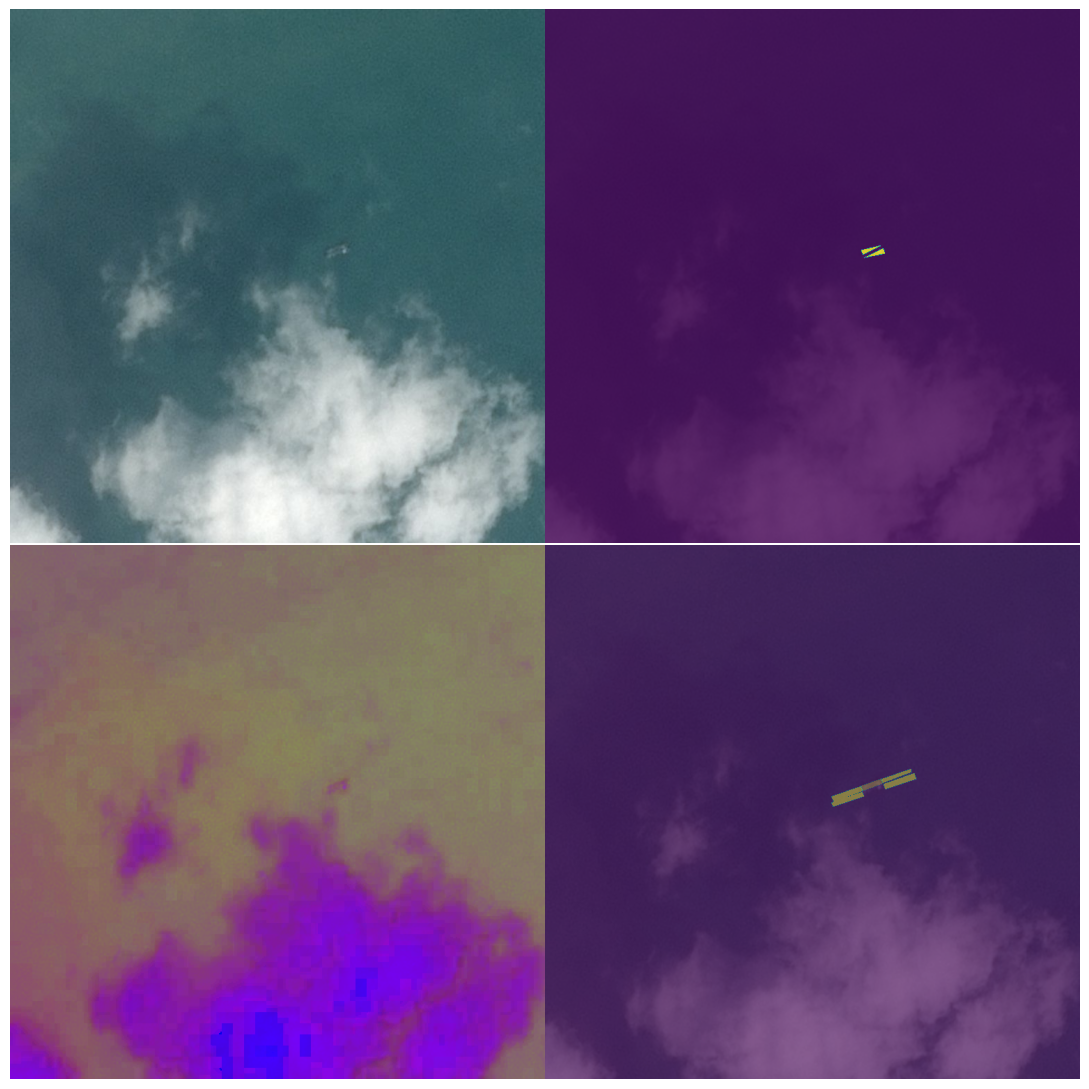

101  :  00a52cd2a.jpg
      Number of Boats :  1



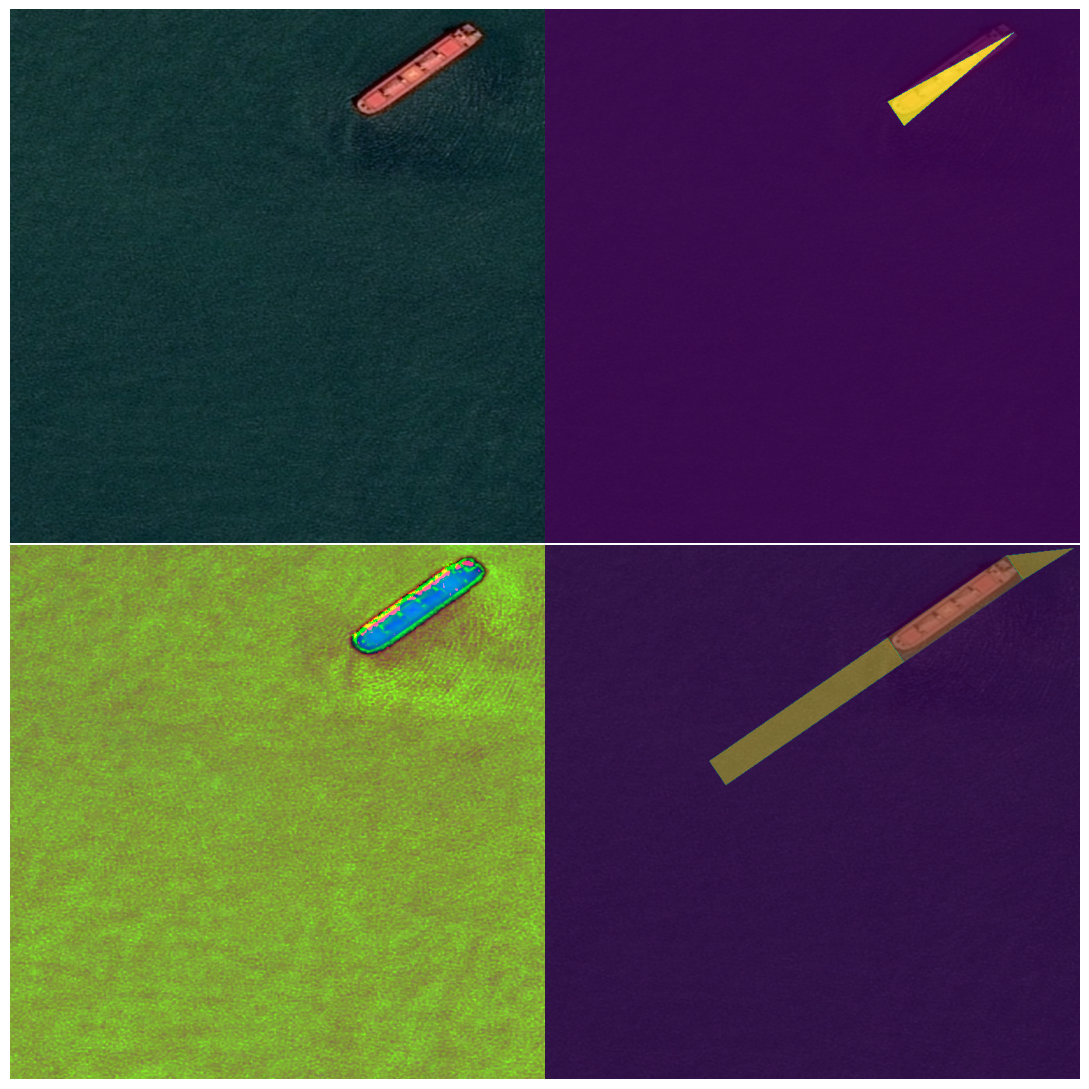

102  :  00a6fef47.jpg
      Number of Boats :  1



In [18]:
data_lenght = len(mask_without_duplicate)
print("Number of Images = ", data_lenght)
print("")

DEBUG = 0                           # 0 affiche que l'image, 1 affiche l'image et le test des couleurs, 2 affiche tout
Start_at_Image = 100                  
Number_Of_Images_To_Process = 100

# 6min 17s pour 0 à 10
for i in range(Start_at_Image,(Start_at_Image+Number_Of_Images_To_Process)):
    function(EncodedPixels[i], ID[i], i, DEBUG)

#  pour 0 à 10 (max_workers=16)
#with ThreadPoolExecutor(max_workers=16) as executor:
    #for i in range(0,10):
        #executor.map(function,EncodedPixels[i], ID[i], i)


      Number of Boats :  1


Boat :  1
right :  [495, 475]
left :  [503, 362]
bottom [522, 366]
top :  [476, 471]

Diagonale : 
c'est x1 le milieu
Top <-> Bottom + Right <-> Left
Liste Contours Coord =  [[476, 471], [495, 475], [476, 471], [503, 362], [522, 366], [495, 475], [522, 366], [503, 362]]
A1 =  [543, 199]
B1 =  [562, 203]
C1 =  [522, 366]
D1 =  [503, 362]
A2 =  [455, 638]
B2 =  [436, 634]
C2 =  [476, 471]
D2 =  [495, 475]
Zone Verte =  [1417.41291525 1764.12974074 1207.76862745]
Zone Rouge =  [1215.72433855  384.44451791 2557.15294118]
Zone Verte =  1562.12185626317
Zone Rouge =  2861.084025813242
La zone Verte est l'avant !


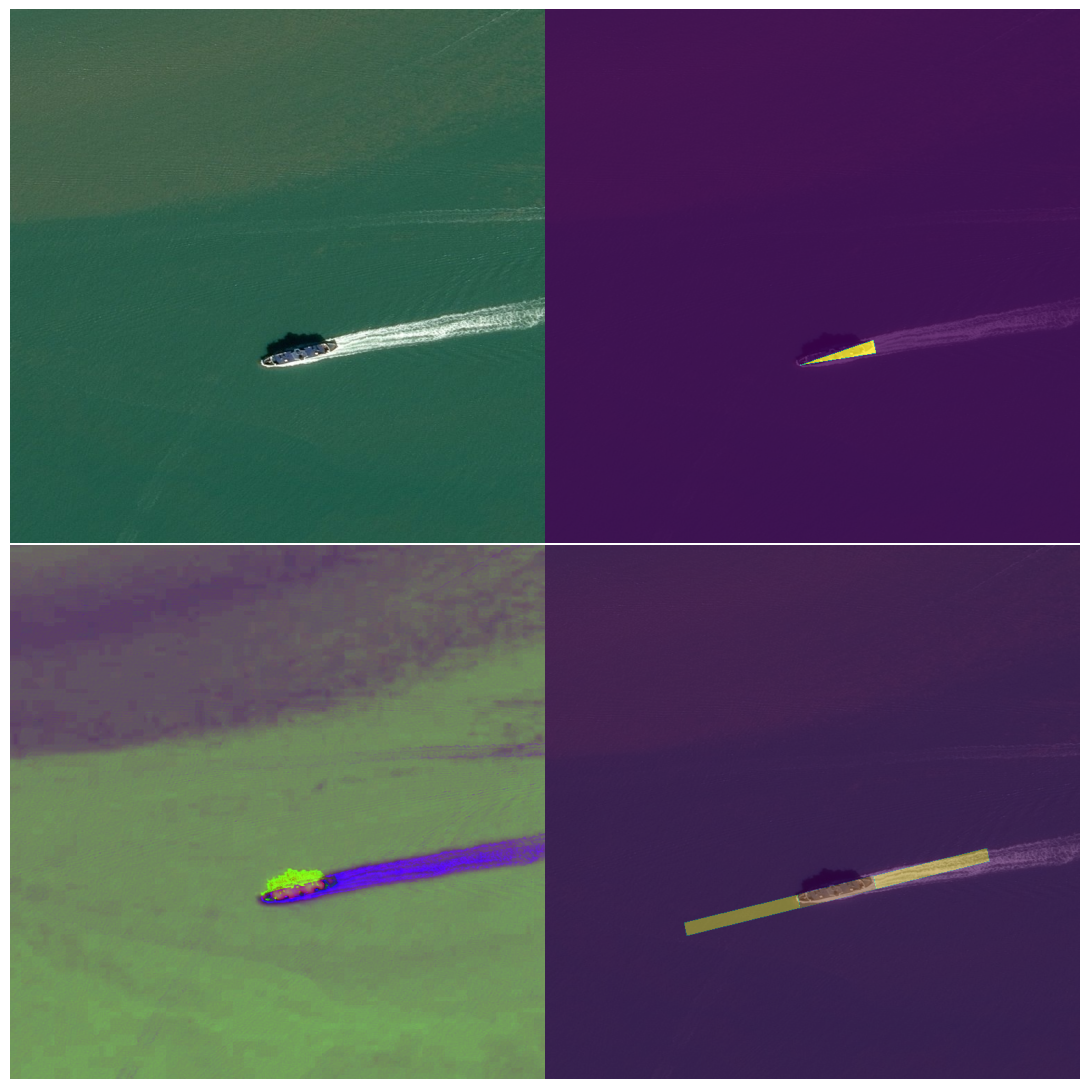

0

In [ ]:
#ImageId = '00b0fa633.jpg'
#ImageId = '00e603959.jpg'
#ImageId = '00c9a7ed3.jpg' #ça bug
ImageId = '014586e74.jpg' #ça bug

DEBUG = 2           # 0 affiche que l'image, 1 affiche l'image et le test des couleurs, 2 affiche tout

algo(ImageId, DEBUG)